In [8]:
%matplotlib inline

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

from kinematics_and_rotation.dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [11]:
gaia_mc0 = pd.read_csv("../data/gaia_mc2.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 5500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
bmin = 10
m &= (gaia_mc1.b.values < bmax) * (bmin < gaia_mc1.b.values)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

gaia_mc = gaia_mc1.iloc[m]
N = len(gaia_mc)
print(N, "stars")

(31357, 133)
(11700, 133) no visual binaries or subgiants
(11436, 133) no large vb uncertainties
(11272, 133) no faint stars
(10586, 133) no rapid rotators
(10454, 133) no hot or cold stars
(4635, 133) no high latitude stars
4635 stars


In [17]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
vb = gaia_mc.vb.values
vberr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
b = gaia_mc.b.values
print(np.shape(vb), np.shape(b))

(4635,) (4635,)


In [14]:
xlim = (maxt + 100, mint - 200)
tbins = np.linspace(min(x), max(x), 10)

period_bins = 10**np.linspace(np.log10(7), np.log10(50), 9)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(gaia_mc, period_bins, "Prot")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [21]:
def sample_model(N, vb, b, beta=.52, slope=.44, intercept=.15):

    # Hierarchical model
    simple_model = pm.Model()

    with simple_model:
    
            # Prior over mu
            mu = pm.Uniform("mu", lower=-100, upper=100)
        
            # Prior over sigma
            sigma = pm.Uniform("sigma", lower=0, upper=100)
        
            # vz
            vz_hat = pm.Normal("vz_hat", mu=mu, sigma=sigma, shape=N) 
        
            # vb (the likelihood)
            vb_hat = pm.Normal("vb_hat", mu=vz_hat, sigma=(slope*b + intercept), observed=vb)
        
    # Sample
    with simple_model:
        trace = pm.sample(tune=5000, draws=5000)
    return trace

In [26]:
print(tbins)

[3501.71336315 3723.34219794 3944.97103274 4166.59986753 4388.22870232
 4609.85753712 4831.48637191 5053.1152067  5274.74404149 5496.37287629]


In [ ]:
pds, pderrs = [np.zeros((len(mid_period_bins), len(tbins[:-1]))) for i in range(2)]

for i, m in enumerate(period_masks):
    print(i, "of", len(period_masks))

    for j in range(len(tbins)-1):
        print(j, "of", len(tbins))
        m2 = (tbins[j] < x[m]) * (x[m] < tbins[j+1])

        if sum(m2) > 0:
            trace = sample_model(len(vb[m][m2]), vb[m][m2], b[m][m2])
    
            pds[i, j] = np.median(trace.sigma)
            pderrs[i, j] = np.std(trace.sigma)

0 of 8
0 of 10
1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:16<00:00, 2422.32draws/s]
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
There were 323 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6844540396587301, but should be close to 0.8. Try to increase the number of tuning steps.
There were 169 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2206 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3861146545091485, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated nu

7 of 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:21<00:00, 1901.16draws/s]
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


8 of 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:18<00:00, 2211.38draws/s]
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46953676566113806, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


1 of 8
0 of 10
1 of 10
2 of 10
3 of 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1540.76draws/s]
There were 385 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39227838447785457, but should be close to 0.8. Try to increase the number of tuning steps.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


4 of 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:30<00:00, 1325.12draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1775 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 8.665237920777124e-09, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


5 of 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vz_hat, sigma, mu]
Sampling 4 chains:  25%|██▌       | 10162/40000 [00:09<00:18, 1617.29draws/s]

In [23]:
cmap = plt.cm.get_cmap('viridis_r')

pvmin, pvmax = np.min(pds[pds > 0]), np.max(pds[np.isfinite(pds)])
pcolor_values = (pds - pvmin)/(pvmax - pvmin)
prgba_plasma = cmap(pcolor_values)

Text(0.5, 0, '$\\mathrm{T_{eff}~[K]}$')

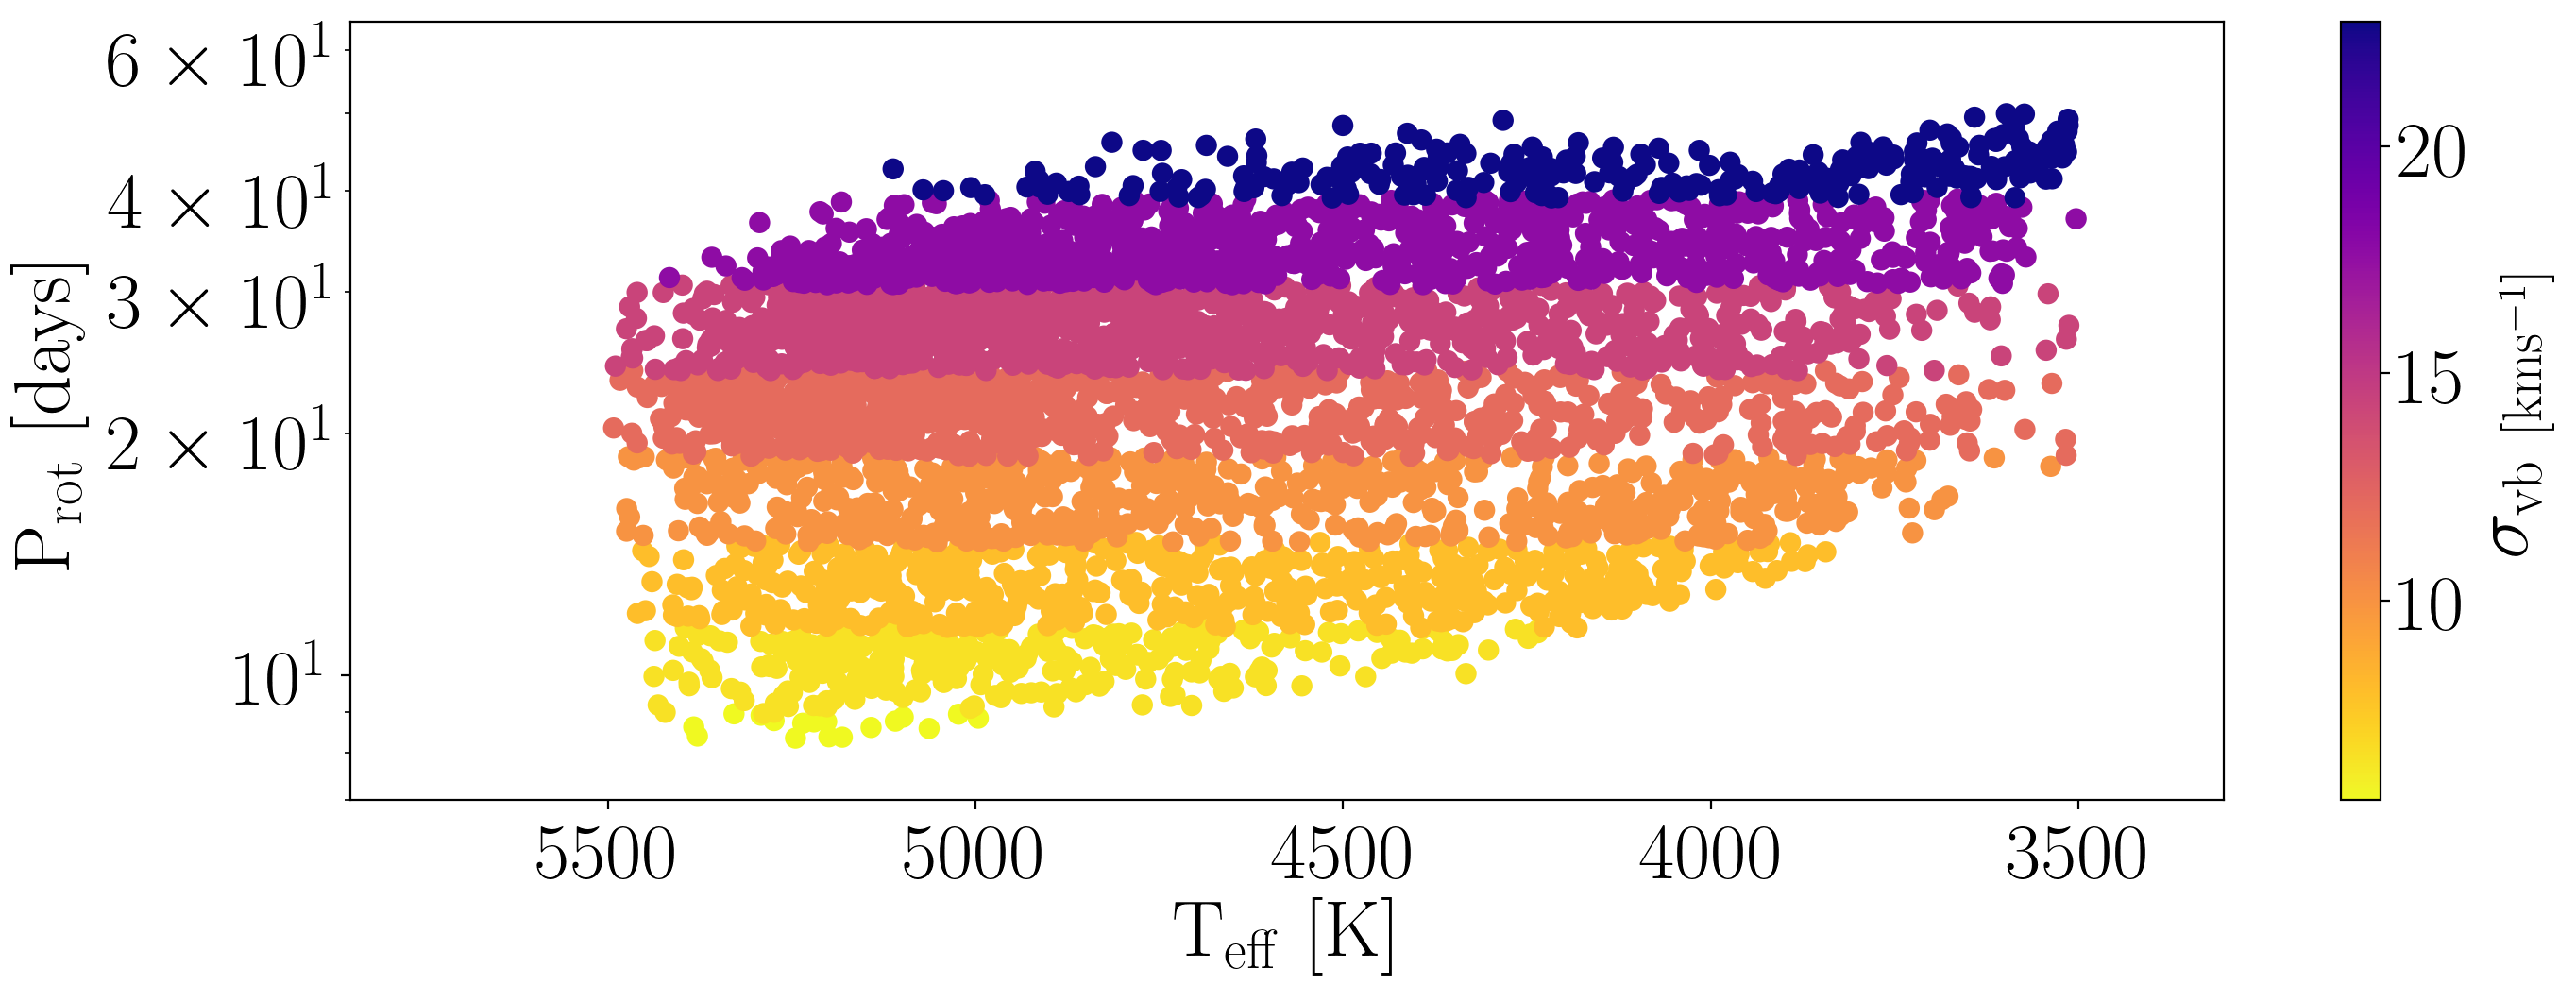

In [25]:
fig = plt.figure(figsize=(16, 12), dpi=200)
ax1 = fig.add_subplot(211)

for i, m in enumerate(period_masks):
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(x[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, rasterized=True, zorder=1, s=50, cmap="plasma_r")   
        
plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax1.set_xlim(5850, min(x)-200)
ax1.set_yscale("log")
ax1.set_ylim(7, 65)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")

In [ ]:
ads = pds**(1./.52)
amin, amax = np.min(ads[ads > 0]), np.max(ads[np.isfinite(ads)])

fig = plt.figure(figsize=(16, 12), dpi=200)
ax1 = fig.add_subplot(211)

for i, m in enumerate(period_masks):
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(x[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*ads[i, j],
                          vmin=amin, vmax=amax, rasterized=True, zorder=1, s=50, cmap="plasma_r")   
        
plt.colorbar(cb1, label="$\mathrm{Age~[Gyr]}$")
ax1.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax1.set_xlim(5850, min(x)-200)
ax1.set_yscale("log")
ax1.set_ylim(7, 65)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")